In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.base import clone
import joblib
from statsmodels.api import OLS
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
import pandas as pd
import math
import joblib

In [3]:
from myflaml import auto_reg, auto_clf, auto_weighted_reg

# Setting the High Level Parameters for the Notebook

In [4]:
time_budget = 10 # budget for auto-ml
verbose = 0 # verbosity of auto-ml
n_splits = 5 # cross-fitting and cross-validation splits
data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare'}
plot = True
feat_ind = 1 # which feature to use as x axis in plotting
# Formula for the BLP of CATE regression.
blp_formula = 'np.log(inc)' # e.g. 'np.log(inc)', 'C(polviews)' for the welfare case. 

## For semi-synthetic data generation; available only if data='401k' 
semi_synth = True # True is available only if data='401k'
simple_synth = True # True is available only if data='401k'
max_depth = 3 # max depth of random forest during for semi-synthetic model fitting
scale = .4 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

# Fetching the Data

The Criteo dataset can be downloaded from here:
https://www.kaggle.com/code/hughhuyton/criteo-uplift-modelling/input
This file should be downloaded and stored in the same folder as the notebook with the name `criteo-uplift-v2.1.csv`.

The welfare dataset can be downloaded from here:
https://github.com/gsbDBI/ExperimentData/blob/master/Welfare/ProcessedData/welfarenolabel3.csv
This file should be downloaded and stored in the same folder as the notebook with the name `welfarenolabel3.csv`.

The 401k dataset is downloaded from the source by the code and no need to further download anything:
https://raw.githubusercontent.com/CausalAIBook/MetricsMLNotebooks/main/data/401k.csv

In [5]:
from datasets import fetch_data_generator

get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth, simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef, max_depth=max_depth)
X, D, y = get_data()

In [6]:
if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')

True ATE: 1.130518323390408


In [7]:
def rmse(cate, preds):
    return np.sqrt(np.mean((cate - preds)**2))

# Data Analysis

We now have our data X, D, y, of controls, treatments and outcomes. We will be assuming throughout that conditional ignorability is satisfied if we control for all the variables $X$, i.e. the potential outcomes $Y(1), Y(0)$ satisfy
\begin{align}
Y(1), Y(0) ~\perp\hspace{-1em}\perp~D \mid X
\end{align}
Equivalently, we assume that the DAG the corresponds to our setting satisfies that $X$ is a valid adjustment set between $D$ and $Y$, i.e. it blocks all backdoor paths in the DAG.

In [8]:
X.describe()

,hrs1,income,rincome,age,polviews,educ,earnrs,sibs,childs,occ80,...,marital_2.0,marital_3.0,marital_4.0,marital_5.0,race_2,race_3,mobile16_2.0,mobile16_3.0,sex_2,born_2.0
count,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,...,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000,12907.000000
mean,42.260324,11.305183,10.223367,40.573952,4.083443,14.026497,1.745177,3.426823,1.569613,332.056016,...,0.028512,0.164484,0.033083,0.245913,0.116526,0.063841,0.272178,0.337181,0.496242,0.087549
std,14.018162,1.635527,2.744435,12.179377,1.376485,2.722665,0.830837,2.918114,1.482378,242.739687,...,0.166436,0.370729,0.178860,0.430644,0.320867,0.244480,0.445098,0.472766,0.500005,0.282649
min,0.000000,1.000000,1.000000,18.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,38.000000,12.000000,9.000000,31.000000,3.000000,12.000000,1.000000,2.000000,0.000000,156.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,40.000000,12.000000,12.000000,40.000000,4.000000,14.000000,2.000000,3.000000,2.000000,305.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,50.000000,12.000000,12.000000,49.000000,5.000000,16.000000,2.000000,4.000000,2.000000,458.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
max,89.000000,12.000000,12.000000,88.000000,7.000000,20.000000,8.000000,37.000000,8.000000,889.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


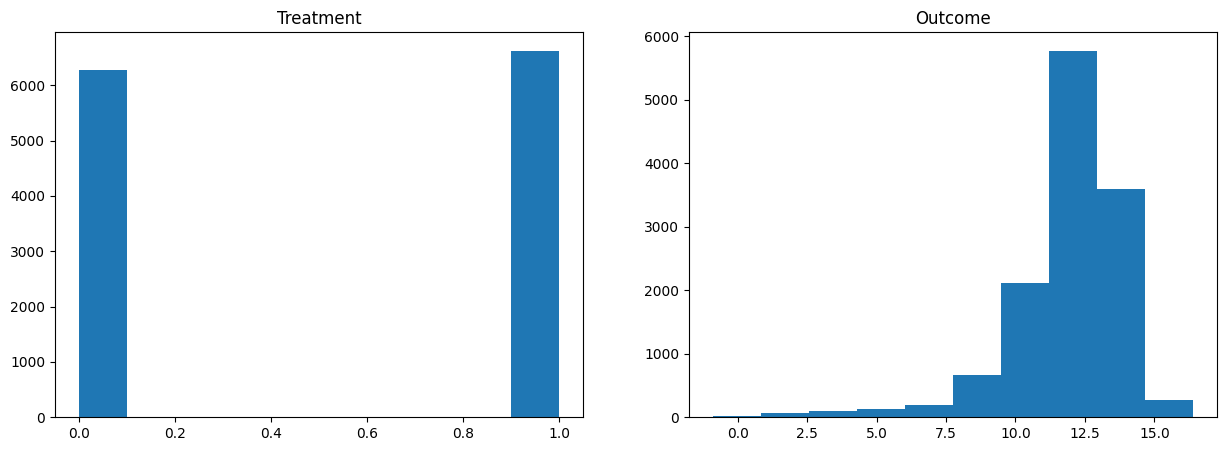

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(D)
plt.title('Treatment')
plt.subplot(1, 2, 2)
plt.hist(y)
plt.title('Outcome')
plt.show()

# Split Train and Validation and Test

The training data will be used to fit the various CATE models. The validation data will be used for scoring and selection of the best CATE model or best ensemble of CATE models. The test data will be used for testing and evaluation of the performance of the best chosen model. 

In [10]:
from sklearn.model_selection import train_test_split
X, Xval, D, Dval, y, yval = train_test_split(X, D, y, train_size=.6, shuffle=True)
Xval, Xtest, Dval, Dtest, yval, ytest = train_test_split(Xval, Dval, yval, train_size=.5, shuffle=True)

# Nuisance Model Selection

Using the training data we will select the best model for each of the nuisance models that arise in meta learner CATE approaches. They five models correspond to the following five predictive problems:
\begin{align}
\text{model_reg} ~\rightarrow~& g(d, x) := E[Y\mid D=d, X=x]\\
\text{model_y} ~\rightarrow~& q(x) := E[Y\mid X=x]\\
\text{model_t} ~\rightarrow~& p(x) := E[D\mid X=x] = \Pr(D=1\mid X=x)\\
\text{model_reg_zero} ~\rightarrow~& g_0(x) := E[Y\mid D=0, X=x]\\
\text{model_reg_one} ~\rightarrow~& g_1(x) := E[Y\mid D=1, X=x]\\
\end{align}
We will select the best hyperparameters/model type for each predictive problem using cross-validation, where the splits are also stratified by the treatment (so that we have balanced split of the treatment groups across folds).

In [11]:
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
splits = list(cv.split(X, D))

In [12]:
model_reg = auto_reg(np.column_stack((D, X)), y, n_splits=n_splits, verbose=verbose, time_budget=time_budget)
model_y = auto_reg(X, y, n_splits=n_splits, verbose=verbose, time_budget=time_budget)
model_t = auto_clf(X, D, n_splits=n_splits, verbose=verbose, time_budget=time_budget)
model_reg_zero = auto_reg(X[D==0], y[D==0], n_splits=n_splits, verbose=verbose, time_budget=time_budget)
model_reg_one = auto_reg(X[D==1], y[D==1], n_splits=n_splits, verbose=verbose, time_budget=time_budget)

In [13]:
model_reg()

AutoMLWrap(model=<flaml.automl.model.ExtraTreesEstimator object at 0x000001F899B55040>)

In [14]:
model_y()

AutoMLWrap(model=<flaml.automl.model.RandomForestEstimator object at 0x000001F899B55760>)

In [15]:
model_t()

AutoMLWrapCLF(model=<flaml.automl.model.LGBMEstimator object at 0x000001F899B55FD0>)

If you want to save or load these models from a previous run un-comment the following lines

In [16]:
# joblib.dump([model_reg(), model_y(), model_t(), model_reg_zero(), model_reg_one()], 'nuisance.jbl')

In [17]:
# mreg, my, mt, mreg_zero, mreg_one = joblib.load('nuisance.jbl')
# model_reg = lambda: clone(mreg)
# model_y = lambda: clone(my)
# model_t = lambda: clone(mt)
# model_reg_zero = lambda: clone(mreg_zero)
# model_reg_one = lambda: clone(mreg_one)

We now also evaluate the performance of the selected models in terms of R^2

In [18]:
from sklearn.model_selection import cross_val_score
score_reg = np.mean(cross_val_score(model_reg(), X, y, cv=n_splits, scoring='r2'))
print(f'model_reg: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_y(), X, y, cv=n_splits, scoring='r2'))
print(f'model_y: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_t(), X, D, cv=n_splits, scoring='r2'))
print(f'model_t: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_reg_zero(), X[D==0], y[D==0], cv=n_splits, scoring='r2'))
print(f'model_reg_zero: {score_reg:.3f}')
score_reg = np.mean(cross_val_score(model_reg_one(), X[D==1], y[D==1], cv=n_splits, scoring='r2'))
print(f'model_reg_one: {score_reg:.3f}')

model_reg: 0.727
model_y: 0.726
model_t: -0.001
model_reg_zero: 0.757
model_reg_one: 0.809


# Nuisance Cross-Fitted Estimation and Prediction

After selecting the hyper-parameters for each of the nuisance models we perform cross-fitting to get out-of-fold predictions from each of these nuisance models. At the end of this process, we will have for each sample $i$, the following out-of-fold nuisance values:
\begin{align}
\text{reg_preds} \rightarrow~& \hat{g}(D_i, X_i) &
\text{reg_one_preds} \rightarrow~& \hat{g}(1, X_i) &
\text{reg_zero_preds} \rightarrow~& \hat{g}(0, X_i)\\
\text{reg_preds_t} \rightarrow~& \hat{g}_0(X_i) (1 - D_i) + \hat{g}_1(X_i) D_i &
\text{reg_one_preds_t} \rightarrow~& \hat{g}_1(X_i) &
\text{reg_zero_preds_t} \rightarrow~& \hat{g}_0(X_i)\\
\text{res_preds} \rightarrow~& \hat{q}(X_i) &
\text{prop_preds} \rightarrow~& \hat{p}(X_i)
\end{align}

In [19]:
from sklearn.model_selection import KFold, cross_val_predict

splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X, D))

n = X.shape[0]
reg_preds = np.zeros(n)
reg_zero_preds = np.zeros(n)
reg_one_preds = np.zeros(n)
reg_preds_t = np.zeros(n)
reg_zero_preds_t = np.zeros(n)
reg_one_preds_t = np.zeros(n)

DX = np.column_stack((D, X))
for train, test in splits:
    reg = model_reg().fit(DX[train], y[train])
    reg_preds[test] = reg.predict(DX[test])
    reg_one_preds[test] = reg.predict(np.column_stack([np.ones(len(test)), X.iloc[test]]))
    reg_zero_preds[test] = reg.predict(np.column_stack([np.zeros(len(test)), X.iloc[test]]))
    
    reg_zero = model_reg_zero().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
    reg_one = model_reg_one().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
    reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
    reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
    reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

res_preds = cross_val_predict(model_y(), X, y, cv=splits)
prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

# CATE Model Estimation

We specify which indices of the X variables we want to use for heterogeneity. Let's denote these subset of variables with $Z$

In [20]:
hetero_inds = np.arange(X.shape[1])
Z, Zval, Ztest = X.iloc[:, hetero_inds], Xval.iloc[:, hetero_inds], Xtest.iloc[:, hetero_inds]

We specify a generic automl approach for training the final CATE model

In [21]:
model_final_fn = lambda Z, y: auto_reg(Z, y, n_splits=n_splits, verbose=verbose, time_budget=time_budget)

### Single Learner (S-Learner)

The S-Learner simply trains a model to predict:
\begin{align}
\hat{g}(1, X_i) - \hat{g}(0, X_i) \sim Z_i
\end{align}

In [22]:
# slearner
slearner_best = model_final_fn(Z, reg_one_preds - reg_zero_preds)
slearner = slearner_best().fit(Z, reg_one_preds - reg_zero_preds)
slearner_cates = slearner.predict(Z)

### Two Learner (T-Learner)

The T-Learner simply trains a model to predict:
\begin{align}
\hat{g}_1(X_i) - \hat{g}_0(X_i) \sim Z_i
\end{align}

In [23]:
# tlearner
tlearner_best = model_final_fn(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner = tlearner_best().fit(Z, reg_one_preds_t - reg_zero_preds_t)
tlearner_cates = tlearner.predict(Z)

### Cross Learner (X-Learner)

The X-Learner simply trains a two treatment effect models using all the variables $X$:
\begin{align}
\hat{\tau}_1: Y_i - \hat{g}_0(X_i) \sim X_i \\
\hat{\tau}_0: \hat{g}_1(X_i) - Y_i \sim X_i
\end{align}
And then for each target sample $X_i$ we select a mixture based on the propensity. 
If $D=1$ is more probable, then we use more heavily $\hat{\tau}_0$, since that uses the model $\hat{g}_1$ which was trained on more data similar to $X_i$ (as indicated by the propensity). Similarly, if $D=0$ is more probably we put more weight on $\hat{\tau}_1$. 
\begin{align}
\hat{\tau}(X_i) = \hat{p}(X_i) \hat{\tau}_0(X_i) + (1 - \hat{p}(X_i)) \hat{\tau}_1(X_i)
\end{align}
Finally, to learn a CATE model that only depends on $Z$, we predict the CATEs $\hat{\tau}$ from $Z$:
\begin{align}
\hat{\tau}(X_i) \sim Z_i
\end{align}

In [24]:
# xlearner
tau1_preds = y[D==1] - reg_zero_preds_t[D==1]
tau0_preds = reg_one_preds_t[D==0] - y[D==0]
tau1 = model_final_fn(X[D==1], tau1_preds)().fit(X[D==1], tau1_preds)
tau0 = model_final_fn(X[D==0], tau0_preds)().fit(X[D==0], tau0_preds)
xtarget = prop_preds * tau0.predict(X) + (1 - prop_preds) * tau1.predict(X)
xlearner = model_final_fn(Z, xtarget)().fit(Z, xtarget)
xlearner_cates = xlearner.predict(Z)

### Doubly Robust Learner (DR-Learner)

The DR-Learner (in particular, the variant based on the T-Learner) adds a de-biasing correction to the T-Learner using the propensity. In particular, we construct the doubly robust variables
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\hat{p}(X_i) (1-\hat{p}(X_i))}
\end{align}
and then we train a CATE model by predicting these variables from $Z_i$:
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) \sim Z_i
\end{align}
For stability we clip the co-variance that appears in the denominator at some value $c$ bounded away from zero, i.e.
\begin{align}
Y_i^{DR}(\hat{g},\hat{p}) := \hat{g}_1(X_i) - \hat{g}_0(X_i) + (Y_i - \hat{g}_{D_i}(X_i))\frac{D_i - \hat{p}(X_i)}{\min\{c, \hat{p}(X_i) (1-\hat{p}(X_i))\}}
\end{align}

In [25]:
# drlearner
dr_preds = reg_one_preds_t - reg_zero_preds_t
dr_preds += (y - reg_preds_t) * (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
drlearner_best = model_final_fn(Z, dr_preds)
drlearner = drlearner_best().fit(Z, dr_preds)
drlearner_cates = drlearner.predict(Z)

### Residual Learner (R-Learner)

The R-Learner uses the fact that if the true CATE model 
$$\theta(X)=E[Y(1)-Y(0)\mid X]$$
only depends on the subset of variables $Z$, then we can write:
\begin{align}
Y =~& \tau(Z) D + b(X) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
This then implies that we can also write:
\begin{align}
Y - E[Y\mid X] =~& \tau(Z) (D - E[D|X]) + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Hence, if we define the residual outcome $\tilde{Y} = Y - E[Y\mid X]$ and the residual treatment $\tilde{D} = D - E[D\mid X]$, then we have:
\begin{align}
\tilde{Y} =~& \tau(Z) \tilde{D} + \epsilon, & E[\epsilon\mid D, X]=~& 0
\end{align}
Thus we can estimate the CATE by predicting $\tilde{Y}$ from $\tilde{D}, Z$ with a separable model of the form $\tau(Z) \tilde{D}$. This also implies that $\tau$ is the minimizer of the square loss:
\begin{align}
E\left[ \left(\tilde{Y} - \tau(Z) \tilde{D}\right)^2 \right]
\end{align}
This loss can also be re-written as a sample-weighted regression loss:
\begin{align}
E\left[ \tilde{D}^2 \left(\tilde{Y}/\tilde{D} - \tau(Z) \right)^2 \right]
\end{align}
We are predicting $\tilde{Y}/\tilde{D}$ form $Z$, using sample weights $\tilde{D}^2$.

If the true CATE $\theta(X)$ did not only depend on $Z$, but on the bigger set of covariates $X$, then this method estimates the best projection of the CATE $\theta(X)$ on the space of functions of $Z$, albeit, in a weighted manner, weighted by the variance of the treatment. More formally, the method estimates the minimizer of the following loss:
\begin{align}
\min_{\tau} E\left[\left(\theta(X) - \tau(Z)\right)^2 \, \text{Var}(D\mid X)\right]
\end{align}

In [26]:
# rlearner
yres = y - res_preds
Dres = D - prop_preds
Dres = np.clip(Dres, .001, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -.001) * (Dres < 0)

rlearner_fn = auto_weighted_reg(Z, yres / Dres, sample_weight=Dres**2,
                                n_splits=n_splits, verbose=verbose, time_budget=time_budget)
rlearner = rlearner_fn().fit(Z, yres / Dres, sample_weight=Dres**2)

rlearner_cates = rlearner.predict(Z)

# Causal Score Estimation and Definition

We want to be able to select among all these different meta learners. For this reason we will use scoring functions that can evaluate the performance of an arbitrary CATE function and is not tailored to any particular methodology. This way we can evaluate all methods using the same score on the validation set and select the best among the methods, or ensemble the methods using this scoring metric. We will describe two such meta scores, the `R-score` and the `DR-score`.

## The Residual Score (R-Score)

The R-score uses the residual loss that we used in the final stage of the R-Learner, to evaluate any CATE model. If we are given any cate model $\hat{\tau}$, then we can evaluate its score on a validation set as:
\begin{align}
L(\hat{\tau}) := E_n\left[\left(\tilde{Y} - \hat{\tau}(Z) \tilde{D}\right)^2\right]
\end{align}
The residuals $\tilde{Y}=Y-E[Y|X]$ and $\tilde{D}=D-E[D|X]$ are constructed in the a cross-fitting manner on the validation set. Moreover, the R-score normalizes this loss, as compared to the score of the best constant effect model $\tau^*=E\left[\tilde{Y}\tilde{D}\right]/E\left[\tilde{D}^2\right]$ and returns an analogue of the R^2:
\begin{align}
\text{Rscore}(\hat{\tau}) := 1 - \frac{L(\hat{\tau})}{L(\tau^*)}
\end{align}

In [27]:
splits_val = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(Xval, Dval))

yres_val = yval - cross_val_predict(model_y(), Xval, yval, cv=splits_val)
Dres_val = Dval - cross_val_predict(model_t(), Xval, Dval, cv=splits_val)
overall_ate_val_r = np.mean(yres_val * Dres_val) / np.mean(Dres_val**2)

def rscore(cate_preds): 
    rscore_t = np.mean((yres_val - cate_preds * Dres_val)**2)
    rscore_b = np.mean((yres_val - overall_ate_val_r * Dres_val)**2)
    return 1 - rscore_t / rscore_b

## The Doubly Robust Score (DR-Score)

The doubly robust score calculates in a cross-fitting manner, using only the validation set, the doubly robust proxy variables $Y_i^{DR}(g,p)$, where $g,p$ are fitted in the validation set in the cross-fitting manner. Then for any candidate CATE model $\hat{\tau}$, the DR-score is simply the R^2 in the regression predicting $Y_i^{DR}(g,p)$ using $Z$, i.e.
\begin{align}
\text{DRscore}(\hat{\tau}) := 1 - \frac{E_n\left[\left(Y^{DR}(g,p) - \hat{\tau}(Z)\right)^2\right]}{\text{Var}\left(Y^{DR}(g,p)\right)}
\end{align}

In [28]:
def calculate_dr_outcomes(X, D, y):
    splits = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(X, D))

    n = X.shape[0]
    reg_preds_t = np.zeros(n)
    reg_zero_preds_t = np.zeros(n)
    reg_one_preds_t = np.zeros(n)

    for train, test in splits:
        reg_zero = model_reg_zero().fit(X.iloc[train][D[train]==0], y[train][D[train]==0])
        reg_one = model_reg_one().fit(X.iloc[train][D[train]==1], y[train][D[train]==1])
        reg_zero_preds_t[test] = reg_zero.predict(X.iloc[test])
        reg_one_preds_t[test] = reg_one.predict(X.iloc[test])
        reg_preds_t[test] = reg_zero_preds_t[test] * (1 - D[test]) + reg_one_preds_t[test] * D[test]

    prop_preds = cross_val_predict(model_t(), X, D, cv=splits)

    dr = reg_one_preds_t - reg_zero_preds_t
    reisz = (D - prop_preds) / np.clip(prop_preds * (1 - prop_preds), .09, np.inf)
    dr += (y - reg_preds_t) * reisz

    return dr

dr_val = calculate_dr_outcomes(Xval, Dval, yval)
overall_ate_val_dr = np.mean(dr_val)

def drscore(cate_preds):
    drscore_t = np.mean((dr_val - cate_preds)**2)
    drscore_b = np.mean((dr_val - overall_ate_val_dr)**2)
    return 1 - drscore_t / drscore_b

# Score CATE Models

We first chose one of the scorers and we score all the CATE models.

In [29]:
scorer = rscore
names = ['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner']
models = [slearner, tlearner, xlearner, drlearner, rlearner]

In [30]:
scores = [scorer(model.predict(Zval)) for model in models]
print([f'{name}: {score:.4f}' for name, score in zip(names, scores)])

['slearner: -0.0035', 'tlearner: -0.0027', 'xlearner: -0.0005', 'drlearner: -0.0026', 'rlearner: -0.0009']


# Plotting CATE

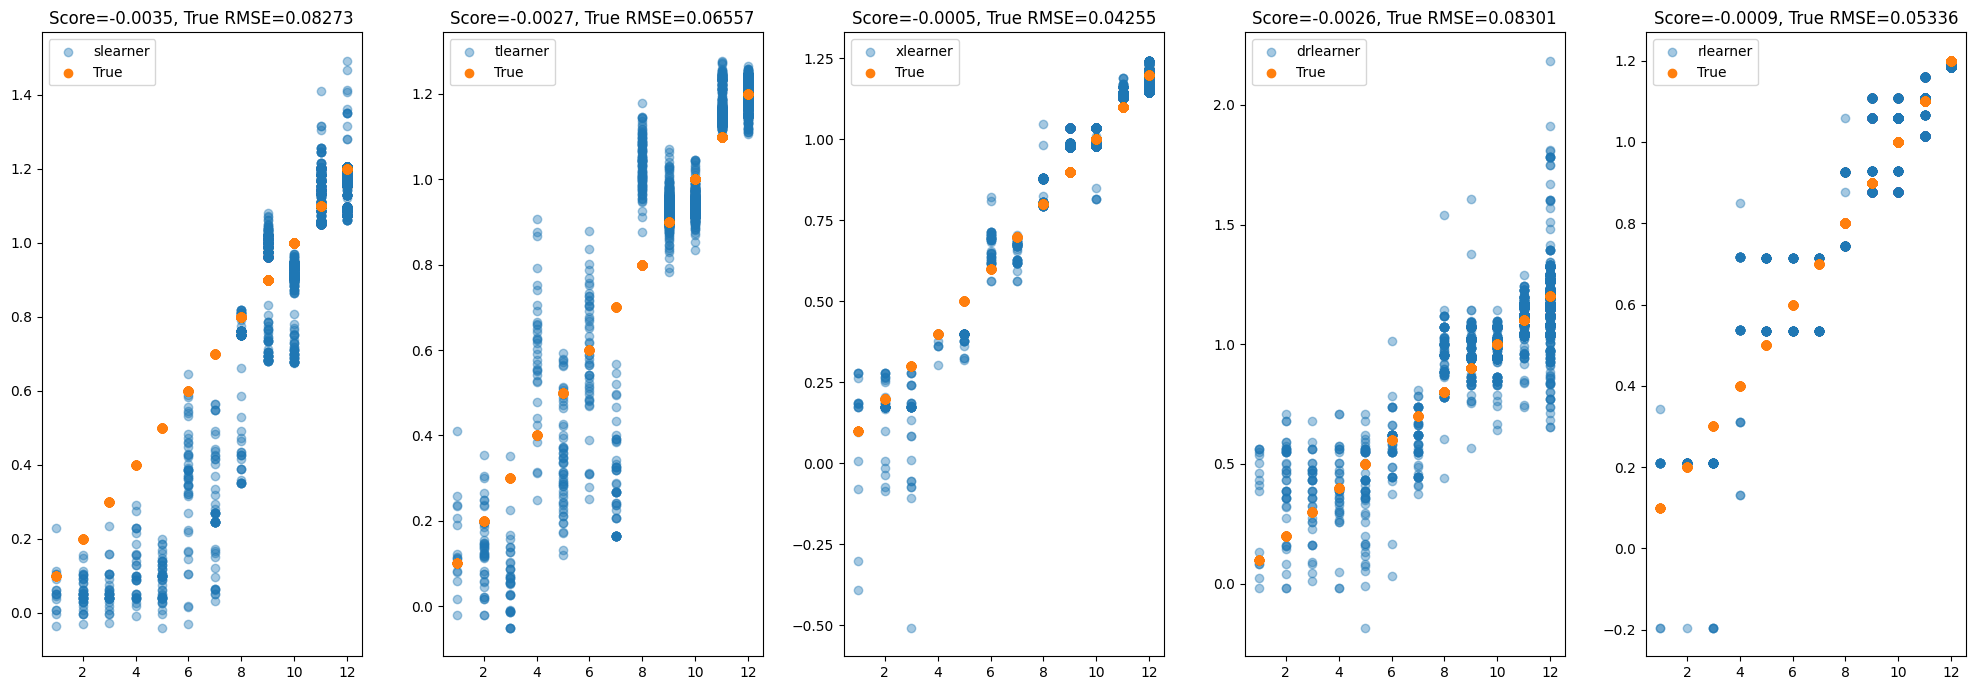

In [31]:
if plot:
    plt.figure(figsize=(20, 7))
    for it, (name, model, score) in enumerate(zip(names, models, scores)):
        plt.subplot(1, len(models), it + 1)
        preds = model.predict(X)
        plt.scatter(X.iloc[:, feat_ind], preds, label=name, alpha=.4)
        plt.scatter(X.iloc[:, feat_ind], true_cate(X), label='True')
        plt.title(f'Score={score:.4f}, True RMSE={rmse(true_cate(X), preds):.5f}')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Causal Model Selection and Ensembling

We can also use these scores to create an ensemble CATE model of the different methods based on the score performance. We want to create a new CATE model $\tau_E$ that is a weighted linear combination of all the cate models, i.e.
\begin{align}
\tau_E(Z) = \sum_{m=1}^M w_m \tau_m(Z)
\end{align}
The weights $w_m$ should be increasing with the score of each CATE model $\tau_m$. Note that it can very well be that the score of the best ensemble is smaller than the score of the best single model, i.e. $\text{Score}(\tau_E) \geq \max_{m} \text{Score}(\tau_m)$. One way to achieve that in a smooth manner to avoid overfitting to the performance measure is to choose weights proportional to $\exp(\eta s_m)$, where $s_m$ is the score of CATE model $\tau_m$. When $\eta=0$ this will return uniform weights over all models and when $\eta\to \infty$, this will return the model with the best score. The "temperature" hyper-parameter $\eta$, can be chosen so that the ensemble achieves the smallest score.

In [32]:
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
    
    def __init__(self, names, models, weights):
        self.names = names
        self.models = models
        self.weights = weights
    
    def predict(self, X):
        return np.sum(self.weights.reshape((-1, 1)) * np.array([m.predict(X) for m in self.models]), axis=0)

In [33]:
eta_grid = np.logspace(-5, 5, 10)
ens = {}
for eta in eta_grid:
    weights = scipy.special.softmax(eta * np.array(scores))
    ensemble = Ensemble(names, models, weights)
    ens[eta] = (ensemble, scorer(ensemble.predict(Zval)))

score_best = -np.inf
for eta in eta_grid:
    if ens[eta][1] >= score_best:
        score_best = ens[eta][1]
        eta_best = eta

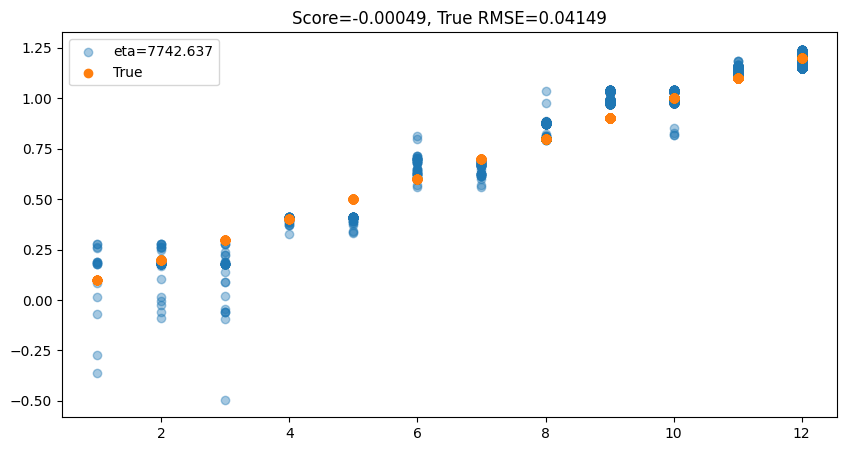

In [34]:
if plot:
    plt.figure(figsize=(10, 5))
    plt.scatter(X.iloc[:, feat_ind], ens[eta_best][0].predict(Z), label=f'eta={eta_best:.3f}', alpha=.4)
    plt.scatter(X.iloc[:, feat_ind], true_cate(X), label='True')
    plt.title(f'Score={ens[eta_best][1]:.5f}, '
              f'True RMSE={rmse(true_cate(X), ens[eta_best][0].predict(Z)):.5f}')
    plt.legend()
    plt.show()

We use the ensemble as our final best model

In [35]:
overall_best = ens[eta_best][0]
overall_best

Ensemble(models=[AutoMLWrap(model=<flaml.automl.model.RandomForestEstimator object at 0x000001F898B45B20>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x000001F899907820>),
                 AutoMLWrap(model=<flaml.automl.model.RandomForestEstimator object at 0x000001F89949D9D0>),
                 AutoMLWrap(model=<flaml.automl.model.LGBMEstimator object at 0x000001F8994FFF40>),
                 AutoMLWrap(model=<flaml.automl.model.ExtraTreesEstimator object at 0x000001F898B36A30>)],
         names=['slearner', 'tlearner', 'xlearner', 'drlearner', 'rlearner'],
         weights=array([6.14883477e-11, 4.10250824e-08, 9.56980830e-01, 7.33391878e-08,
       4.30190557e-02]))

# Validation Tests on Test Data

Now that we have a selected a winning CATE model (or ensemble), we can run a set of hypothesis tests and other diagnostic metrics on the test set, to see if the model really picked up some dimensions of effect heterogeneity and satisfies some self-conistency checks.

### Hypothesis Test Based on Doubly Robust Best-Linear Predictor of CATE using model of CATE

If we calculate the doubly robust pseudo outcomes $Y^{DR}(g,p)$ on the test set, using cross-fitting to estimate the models $g,p$, then we know that if the model of the CATE $\hat{\tau}$ is good, then the best linear predictor of the true CATE using $(1, \hat{\tau}(Z))$ as features should have a statistically significant coefficient on the feature associated with the CATE model. In fact, in an ideal world it should have a coefficient of $1$. Thus we can run such a significance test to measure whether the CATE model $\tau_m$ has picked up anything signal that is correlated with the true CATE. Note that if $\theta(X)$ is the true CATE $E[Y(1)-Y(0)\mid X]$, then the coefficient associated with $\hat{\tau}$ in this regression can be interpreted as identifying the quantity:
\begin{align}
\beta_1 := \frac{\text{Cov}(\theta(X), \hat{\tau}(Z))}{\text{Var}(\hat{\tau}(Z))}
\end{align}

In [36]:
dr_test = calculate_dr_outcomes(Xtest, Dtest, ytest)
cate_test = overall_best.predict(Ztest)

In [37]:
OLS(dr_test, np.stack((np.ones(len(dr_test)), cate_test), axis=-1)).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     11.24
Date:                Thu, 09 Mar 2023   Prob (F-statistic):           0.000811
Time:                        01:05:42   Log-Likelihood:                -5222.2
No. Observations:                2582   AIC:                         1.045e+04
Df Residuals:                    2580   BIC:                         1.046e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2155      0.271      0.795      0.427      -0.316       0.747
x1             0.7974      0.238      3.353      0.001       0.331       1.264
==============================================================================
Omnibus:                        5.830   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                6.390
Skew:                           0.058   Prob(JB):                       0.0410
Kurtosis:                       3.215   Cond. No.                         15.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Validation Based on Calibration

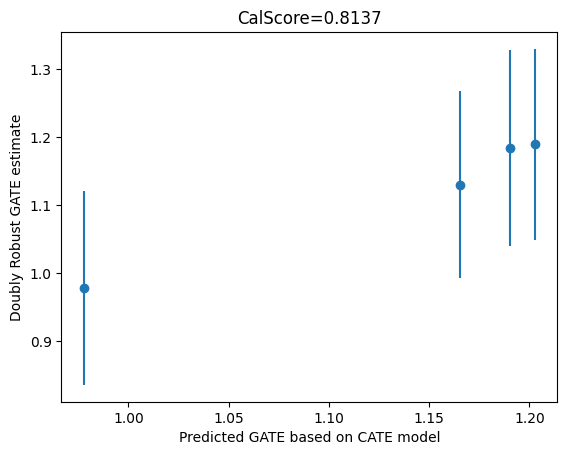

In [38]:
cate_val = overall_best.predict(Zval)
qs = np.percentile(cate_val, np.arange(0, 101, 25))

gate, gate_std, group_prob = np.zeros(len(qs) - 1), np.zeros(len(qs) - 1), np.zeros(len(qs) - 1)
predicted_gate = np.zeros(len(qs) - 1)
for it in range(len(qs) - 1):
    # samples in the [q[it], q[it+1]) quantile group of predicted CATEs
    inds = (qs[it] <= cate_test) & (cate_test < qs[it + 1]) 
    gate[it] = np.mean(dr_test[inds]) # DR estimate of group average treatment effect (GATE)
    gate_std[it] = np.std(dr_test[inds])/np.sqrt(np.sum(inds)) # standard error of GATE
    group_prob[it] = np.mean(inds) # probability mass of group
    predicted_gate[it] = np.mean(cate_test[inds]) # GATE as calculated from CATE model

# weighted average calibration error of cate model
cal = np.sum(group_prob * np.abs(gate - predicted_gate))
# weighted average calibration error of a constant cate model
calbase = np.sum(group_prob * np.abs(gate - np.mean(dr_test)))
# calibration score
calscore = 1 - cal/calbase
plt.title(f'CalScore={calscore:.4f}')
plt.errorbar(predicted_gate, gate, yerr=1.96*gate_std, fmt='o')
plt.xlabel('Predicted GATE based on CATE model')
plt.ylabel('Doubly Robust GATE estimate')
plt.show()

### Validation Based on Uplift Curves

These curves are related to "prioritization" or "stratification" implications of the CATE model. What if we target to treat a $q$-percentage of the population. Then if we trust and follow the CATE model, then we should be offering the treatment to the parts of the population that the CATE model predicts have a CATE larger than the $1-q$-th percentile of the CATE distribution as produced by the CATE.

In this case, we might care about the group average treatment effect of the group of people that are treated under such a prioritization rule and how that compares with the overall average treatment effect. Ideally, the group average treatment effect should be larger than the overall average treatment effect if the prioritization rule is correct.

Thus if we have a rough estimate $\hat{\mu}(q)$ of the $1-q$-quantile $\mu(q)$ of the CATE predictions distribution we can calculate:
\begin{align}
\tau(q) = E[Y(1) - Y(0) \mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]
\end{align}
We can get such good quantile estimates out-of-sample, by looking at the $1-q$-the empirical quantile of the cate predictions on a sample other than the one that we are using to calculate $\tau(q)$. For instance, we can use the training/validation samples but not the test samples. This gives us a set of thresholds $\hat{\mu}(q_1), \ldots, \hat{\mu}(q_m)$ that are good approximations of the quantile of the predicted CATE distribution. If we target to treat every person with CATE greater than $\hat{\mu}(q_t)$ we should expect roughly $q_t$ fraction of the population to be treated.

We can then plot the curve $\tau(q)$, understand the Area Under the Curve:
\begin{align}
AUTOC := \int_0^1 \tau(q) dq
\end{align}
and run tests whether that area is positive or that there is any positive point in the curve. These are tests that indicate that the CATE model detected heterogeneity with statistical significance. Moreover, the larger the Area Under the Curve, the better the CATE model is at treatment prioritization.

In [39]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

dgate, dgate_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_dgate = np.zeros(len(qs))
psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test) # group with larger CATE prediction than the q-th quantile
    group_prob = np.sum(inds) / n # fraction of population in this group
    dgate[it]= np.mean(dr_test[inds]) - ate # E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    psi[it, :] = (dr_test - ate) * (inds / group_prob - 1) - dgate[it] # influence function for the dgate
    dgate_std[it] = np.sqrt(np.mean(psi[it]**2) / n) # standard error of dgate
    if semi_synth:
        true_dgate[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds * n / np.sum(inds) - 1))

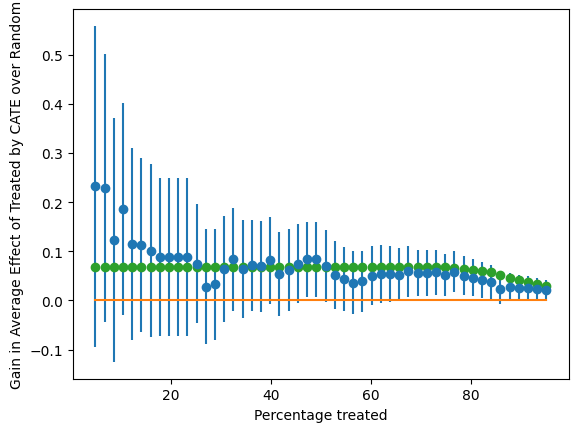

In [40]:
plt.errorbar(100 - ugrid, dgate, yerr=1.96*dgate_std, fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_dgate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.show()

#### Uniform Confidence Band with Multiplier Bootstrap

In fact the "1.96" is wrong if we want the confidence intervals to hold simultaneoulsy for the whole curve. To have such "simultaneous coverage" guarantees we need to calculate a larger "critical value" than 1.96. We can calculate the appropriate such constant using the multiplier bootstrap, which tries to estimate the maximum deviation around the mean as a multiple of the standard deviation for each point. 

In [41]:
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / dgate_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (psi / dgate_std.reshape(-1, 1)) @ w / n
max_mboot = np.max(np.abs(mboot), axis=0)
uniform_critical_value = np.percentile(max_mboot, 95)
print(uniform_critical_value)

2.9134117733185088


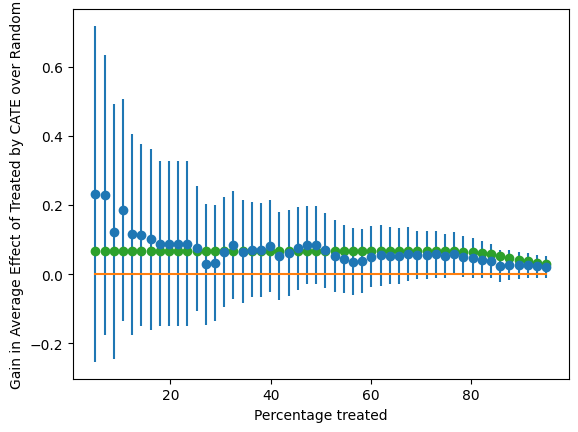

In [42]:
plt.errorbar(100 - ugrid, dgate, yerr=uniform_critical_value*dgate_std, fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_dgate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Average Effect of Treated by CATE over Random")
plt.show()

Note that if there is any point that is above the zero line, with confidence, in this curve, then the CATE model $\hat{\tau}$ has identified heterogeneity in the effect in a statistically significant manner. To do this we need a one-sided confidence interval, as we only care that the quantities are larger than some value with high confidence. We can then calculate the critical value for a uniform one-sided confidence interval across all the points, using the multiplier bootstrap. 

In [43]:
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / dgate_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (psi / dgate_std.reshape(-1, 1)) @ w / n
min_mboot = np.min(mboot, axis=0)
uniform_critical_value = np.abs(np.percentile(max_mboot, 5))
print(uniform_critical_value)

1.074260096514853


In [44]:
print(f'Heterogeneity Statistic: {np.max(dgate - uniform_critical_value*dgate_std)}')

Heterogeneity Statistic: 0.07905756691522783


We can also calcualte the area under the curve and the confidence interval for that area. If the confidence interval does not contain zero, then we have again detected heterogeneity.

In [45]:
autoc_psi = np.sum(psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
autoc = np.sum(dgate[:-1] * np.diff(ugrid) / 100)
autoc_stderr = np.sqrt(np.mean(autoc_psi**2) / n)
print(f'AUTOC: {autoc:.4f}, s.e.: {autoc_stderr:.4f}, '
      f'One-Sided 95% CI=[{autoc - scipy.stats.norm.ppf(.95) * autoc_stderr:.4f}, Infty]')

AUTOC: 0.0598, s.e.: 0.0319, One-Sided 95% CI=[0.0074, Infty]


### Qini Curve

Similar to the $\tau(q)$ curve, we can also consider a small variant of that curve that also incorporates the probability of treatment. So instead of looking just at the group average effect of the group of people that are prioritized by the CATE model and subtract the overall effect, we can look at the "total value" exctracted by the treated group and contrast it with the total value that would be extracted by an equally large group treated uniformly at random. This corresponds to:
\begin{align}
\tau_{\text{QINI}}(q) := q \tau(q) = \left(E[Y(1) - Y(0)\mid \hat{\tau}(Z) \geq \hat{\mu}(q)] - E[Y(1) - Y(0)]\right) q
\end{align}

Similarly, we can look at the area under this curve:
\begin{align}
\text{QINI} := \int_0^1 q\tau(q) dq
\end{align}
which is known as the QINI coefficient.

In [46]:
# Based on out-of-sample CATE thresholds
ugrid = np.linspace(5, 95, 50)
qs = np.percentile(overall_best.predict(Zval), ugrid)

dgate, dgate_std, group_prob = np.zeros(len(qs)), np.zeros(len(qs)), np.zeros(len(qs))
true_dgate = np.zeros(len(qs))
psi = np.zeros((len(qs), dr_test.shape[0]))
n = len(dr_test)
ate = np.mean(dr_test)
for it in range(len(qs)):
    inds = (qs[it] <= cate_test) # group with larger CATE prediction than the q-th quantile
    group_prob = np.sum(inds) / n # fraction of population in this group
    dgate[it] = group_prob * (np.mean(dr_test[inds]) - ate) # q * E[Y(1) - Y(0) | tau(X) >= q[it]] - E[Y(1) - Y(0)]
    psi[it, :] = (dr_test - ate) * (inds - group_prob) - dgate[it] # influence function for the dgate
    dgate_std[it] = np.sqrt(np.mean(psi[it]**2) / n) # standard error of dgate
    if semi_synth:
        true_dgate[it] = np.mean((true_cate(Xtest) - np.mean(true_cate(Xtest))) * (inds - group_prob))

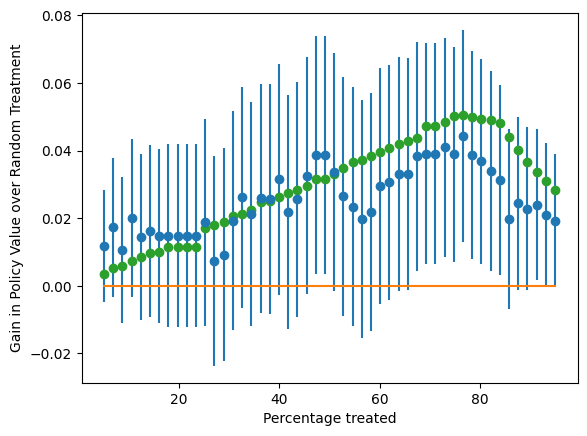

In [47]:
plt.errorbar(100 - ugrid, dgate, yerr=1.96*dgate_std, fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_dgate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Value over Random Treatment")
plt.show()

In [48]:
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / dgate_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (psi / dgate_std.reshape(-1, 1)) @ w / n
max_mboot = np.max(np.abs(mboot), axis=0)
uniform_critical_value = np.percentile(max_mboot, 95)
print(uniform_critical_value)

2.8564585232731234


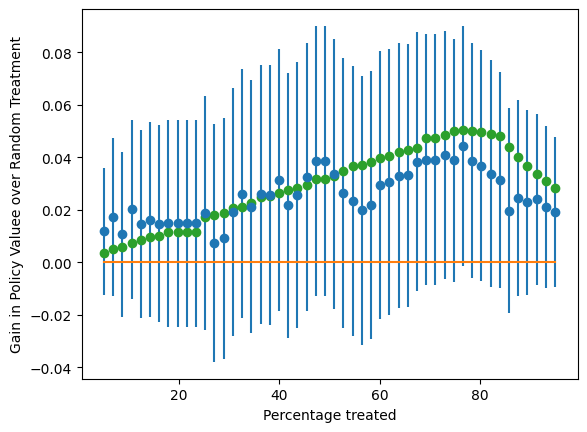

In [49]:
plt.errorbar(100 - ugrid, dgate, yerr=uniform_critical_value*dgate_std, fmt='o')
plt.plot(100 - ugrid, np.zeros(len(ugrid)))
if semi_synth:
    plt.plot(100 - ugrid, true_dgate, 'o')
plt.xlabel("Percentage treated")
plt.ylabel("Gain in Policy Valuee over Random Treatment")
plt.show()

In [50]:
if dr_test.shape[0] > 1e6:
    mboot = np.zeros((len(qs), 1000))
    for it in range(1000):
        w = np.random.normal(0, 1, size=(dr_test.shape[0],))
        mboot[:, it] = (psi / dgate_std.reshape(-1, 1)) @ w / n
else:
    w = np.random.normal(0, 1, size=(dr_test.shape[0], 1000))
    mboot = (psi / dgate_std.reshape(-1, 1)) @ w / n
min_mboot = np.min(mboot, axis=0)
uniform_critical_value = np.abs(np.percentile(max_mboot, 5))
print(uniform_critical_value)

1.0792448499382334


In [51]:
print(f'Heterogeneity Statistic: {np.max(dgate - uniform_critical_value*dgate_std)}')

Heterogeneity Statistic: 0.026972226256618603


In [52]:
qini_psi = np.sum(psi[:-1] * np.diff(ugrid).reshape(-1, 1) / 100, 0)
qini = np.sum(dgate[:-1] * np.diff(ugrid) / 100)
qini_stderr = np.sqrt(np.mean(qini_psi**2) / n)
print(f'QINI: {qini:.4f}, s.e.: {qini_stderr:.4f}, '
      f'One-Sided 95% CI=[{qini - scipy.stats.norm.ppf(.95) * qini_stderr:.4f}, Infty]')

QINI: 0.0231, s.e.: 0.0106, One-Sided 95% CI=[0.0057, Infty]


# Confidence Intervals on BLPs of CATE with the DRLearner

In [53]:
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
Xpoly = PolynomialFeatures(degree=1, include_bias=True).fit_transform(Z)
lr = OLS(dr_preds, Xpoly).fit()
pred_df = lr.get_prediction(Xpoly).summary_frame(alpha=.01)

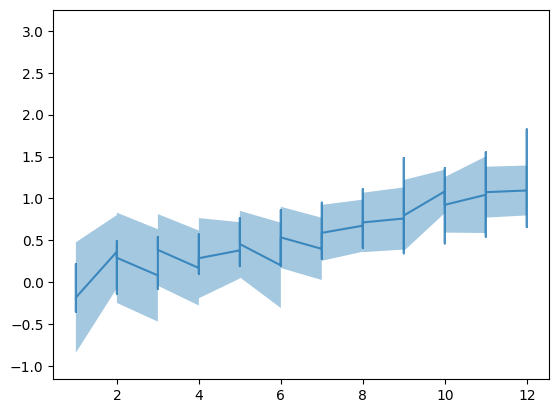

In [54]:
inds = np.argsort(X.iloc[:, feat_ind])
plt.fill_between(X.iloc[inds, feat_ind], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.plot(X.iloc[inds, feat_ind], pred_df['mean'][inds], alpha=.8)
plt.show()

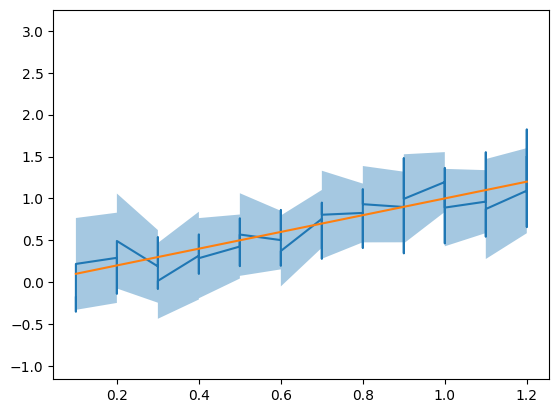

In [55]:
if semi_synth:
    inds = np.argsort(X.iloc[:, feat_ind])
    true_proj = LinearRegression().fit(Xpoly, true_cate(X)).predict(Xpoly)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], pred_df['mean'][inds])
    plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.show()

In [56]:
from statsmodels.formula.api import ols
df = Z.copy()
df['dr'] = dr_preds
lr = ols('dr ~ ' + blp_formula, df).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.099
Date:                Thu, 09 Mar 2023   Prob (F-statistic):              0.360
Time:                        01:05:51   Log-Likelihood:                -15744.
No. Observations:                7744   AIC:                         3.150e+04
Df Residuals:                    7737   BIC:                         3.155e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0861      0.128      8.492      0.000       0.835       1.337
C(polviews)[T.2.0]    -0.0571      0.141     -0.405      0.685      -0.333       0.219
C(polviews)[T.3.0]     0.0455      0.140      0.325      0.745      -0.229       0.320
C(polviews)[T.4.0]     0.0565      0.133      0.426      0.670      -0.203       0.316
C(polviews)[T.5.0]     0.1124      0.138      0.817      0.414      -0.157       0.382
C(polviews)[T.6.0]     0.0113      0.139      0.081      0.935      -0.261       0.284
C(polviews)[T.7.0]    -0.1019      0.180     -0.567      0.570      -0.454       0.250
==============================================================================
Omnibus:                        0.976   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.614   Jarque-Bera (JB):                0.965
Skew:                           0.027   Prob(JB):                        0.617
Kurtosis:                       3.005   Cond. No.                         18.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [57]:
pred_df = lr.get_prediction(df).summary_frame(alpha=.01)

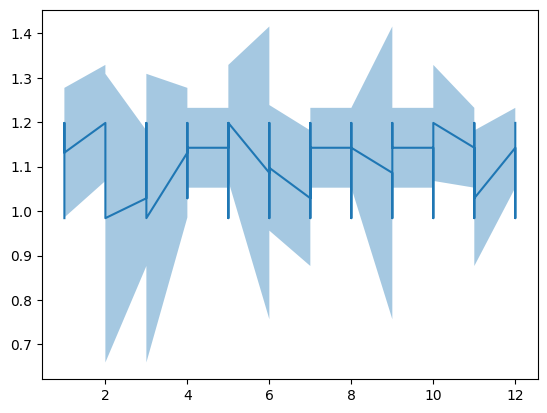

In [58]:
inds = np.argsort(df.iloc[:, feat_ind])
plt.plot(df.iloc[:, feat_ind].iloc[inds], pred_df['mean'][inds])
plt.fill_between(df.iloc[:, feat_ind].iloc[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
plt.show()

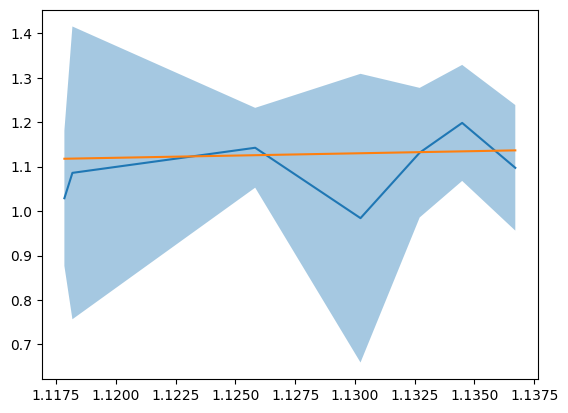

In [59]:
if semi_synth:
    df = Z.copy()
    df['cate'] = true_cate(X)
    lr = ols('cate ~ ' + blp_formula, df).fit()
    true_proj = lr.get_prediction(df).summary_frame(alpha=.01)['mean']
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], pred_df['mean'][inds])
    plt.fill_between(true_proj[inds], pred_df['mean_ci_lower'][inds], pred_df['mean_ci_upper'][inds], alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.show()

# Non-Parametric Confidence Intervals with Causal Forests

In [60]:
from econml.grf import CausalForest

yres = y - res_preds
Dres = D - prop_preds
est = CausalForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50, min_weight_fraction_leaf=.0)
est.fit(Z, Dres, yres)

CausalForest(max_depth=5, max_samples=0.4, min_samples_leaf=50,
             n_estimators=4000)

In [61]:
top_feat = np.argsort(est.feature_importances_)[-1]
print(Z.columns[top_feat])

income


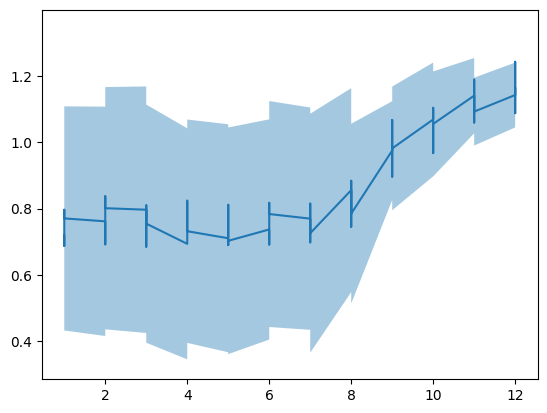

In [62]:
inds = np.argsort(Z.iloc[:, top_feat])
preds, lb, ub = est.predict(Z, interval=True, alpha=.01)
plt.plot(Z.iloc[:, top_feat].iloc[inds], preds[inds])
plt.fill_between(Z.iloc[:, top_feat].iloc[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.show()

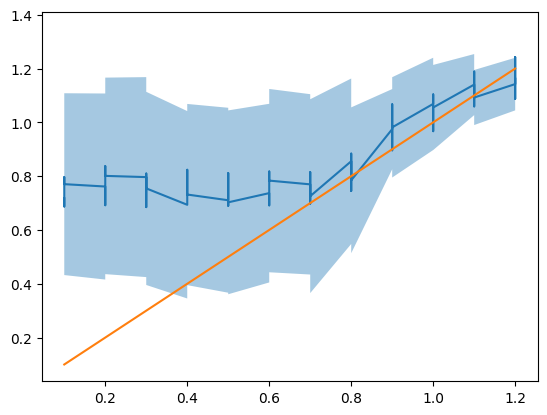

In [63]:
if semi_synth:
    true_proj = true_cate(X)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.show()

# Non-Parametric Confidence Intervals with Doubly Robust Forests

In [64]:
from econml.grf import RegressionForest

est = RegressionForest(4000, max_depth=5, max_samples=.4, min_samples_leaf=50,
                       min_weight_fraction_leaf=.0, n_jobs=1, verbose=3)
est.fit(Z, dr_preds)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:  1.3min finished


RegressionForest(max_depth=5, max_samples=0.4, min_samples_leaf=50,
                 n_estimators=4000, n_jobs=1, verbose=3)

In [65]:
top_feat = np.argsort(est.feature_importances_)[-1]
print(Z.columns[top_feat])

income


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    8.2s finished


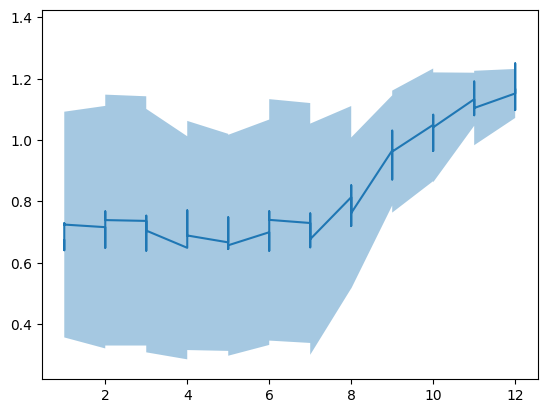

In [66]:
inds = np.argsort(Z.iloc[:, top_feat])
preds, lb, ub = est.predict(Z, interval=True, alpha=.01)
plt.plot(Z.iloc[:, top_feat].iloc[inds], preds[inds])
plt.fill_between(Z.iloc[:, top_feat].iloc[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
plt.show()

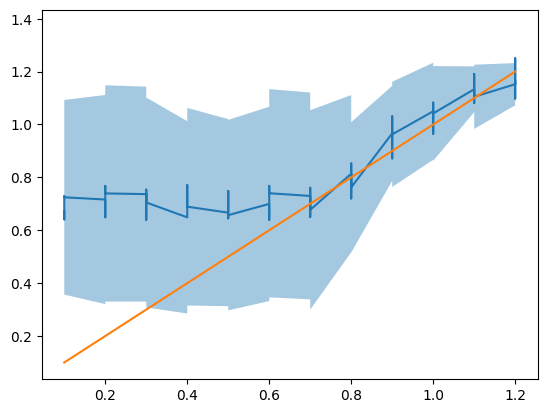

In [67]:
if semi_synth:
    true_proj = true_cate(X)
    inds = np.argsort(true_proj)
    plt.plot(true_proj[inds], preds[inds])
    plt.fill_between(true_proj[inds], lb[inds].flatten(), ub[inds].flatten(), alpha=.4)
    plt.plot(np.linspace(np.min(true_proj), np.max(true_proj), 100),
             np.linspace(np.min(true_proj), np.max(true_proj), 100))
    plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4000 out of 4000 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.4s finished


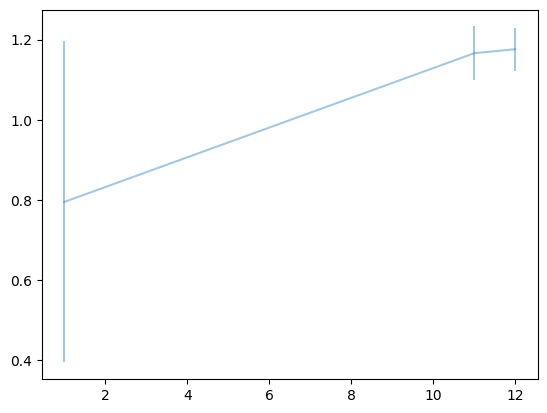

In [68]:
grid = np.unique(np.percentile(Z.iloc[:, top_feat], np.arange(0, 110, 20)))
Zpd = pd.DataFrame(np.tile(np.median(Z, axis=0, keepdims=True), (len(grid), 1)),
                    columns=Z.columns)
Zpd.iloc[:, top_feat] = grid

preds, lb, ub = est.predict(Zpd, interval=True, alpha=.01)
preds = preds.flatten()
lb = lb.flatten()
ub = ub.flatten()
plt.errorbar(Zpd.iloc[:, top_feat], preds, yerr=(preds-lb, ub-preds), alpha=.4)
plt.show()